In [ ]:

%load_ext autoreload
%autoreload 2

from typing import List, Optional
from omegaconf import OmegaConf
import os
import time
import json
import wandb
import logging
import argparse

import torch
import numpy as np
from datasets.driving_dataset import DrivingDataset
from datasets.my_dataset import MyDataset
from utils.misc import import_str
from models.trainers import BasicTrainer
from models.video_utils import (
    render_images,
    save_videos,
    render_novel_views
)


In [ ]:
cfg = OmegaConf.load(os.path.join("/mnt/e/Output/cam5/023", "config.yaml"))
%cd /home/a/drivestudio

dataset = MyDataset(cfg.data)

In [64]:
source = dataset.lidar_source
points = source.origins + source.directions * source.ranges
grounds = source.grounds
flow_class = source.flow_classes
points.shape, grounds.shape, flow_class.shape

(torch.Size([19281220, 3]), torch.Size([19281220]), torch.Size([19281220]))

In [70]:
flow_class[flow_class >= 1].shape

torch.Size([3062494])

In [ ]:
import matplotlib.pyplot as plt

def plot_lidar_points(lidar_points, ground_mask=None):
    plt.figure(figsize=(10, 10))
    plt.scatter(lidar_points[:, 0][~ground_mask], lidar_points[:, 1][~ground_mask], c='b', s=1)  # 2D scatter plot
    plt.title('2D Lidar Points')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.axis('equal')
    plt.grid(True)
    plt.show()

plot_lidar_points(points.numpy(), grounds.numpy())  # Convert to numpy array for plotting


In [117]:
import torch.nn.functional as F

def create_voxel_grid_2d(lidar_points, voxel_size=1):
    z = lidar_points[:, 2]
    lidar_points = lidar_points[(-1 <= z) & (z <= 3)]
    x_min, x_max = lidar_points[:, 0].min(), lidar_points[:, 0].max()
    y_min, y_max = lidar_points[:, 1].min(), lidar_points[:, 1].max()
    
    grid_size_x = int((x_max - x_min) / voxel_size) + 1
    grid_size_y = int((y_max - y_min) / voxel_size) + 1
    
    voxel_grid = torch.zeros((grid_size_x, grid_size_y), dtype=torch.int32)
    
    # 计算每个点的体素索引
    voxel_indices_x = ((lidar_points[:, 0] - x_min) / voxel_size).long()
    voxel_indices_y = ((lidar_points[:, 1] - y_min) / voxel_size).long()
    
    # 将二维索引展平成一维索引
    flat_indices = voxel_indices_x * grid_size_y + voxel_indices_y
    
    # 使用 torch.bincount 统计每个体素的点数量
    counts = torch.bincount(flat_indices, minlength=grid_size_x * grid_size_y)
    
    # 将一维结果重塑为二维网格
    voxel_grid = counts.view(grid_size_x, grid_size_y)
    
    return voxel_grid

p = points[~grounds]
c = flow_class[~grounds]

# 生成2D体素网格
voxel_grid_2d = create_voxel_grid_2d(p[c<=0])


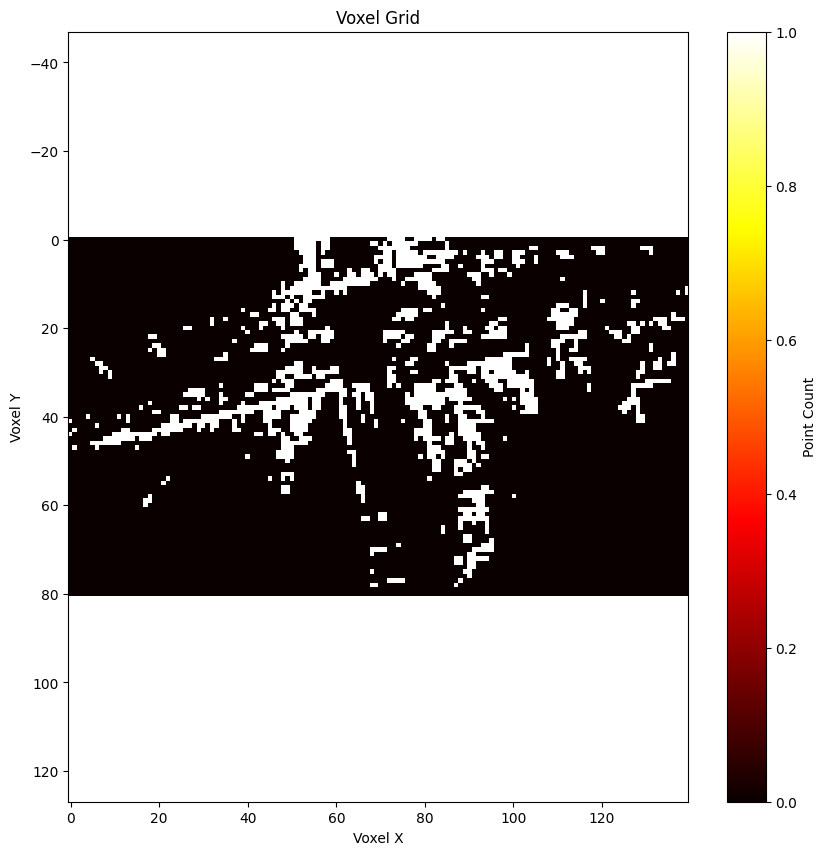

In [122]:
plt.figure(figsize=(10, 10))
plt.imshow(voxel_grid_2d.numpy() > 3, cmap='hot', interpolation='nearest')
plt.title('Voxel Grid')
plt.xlabel('Voxel X')
plt.ylabel('Voxel Y')
plt.colorbar(label='Point Count')
plt.axis('equal')
plt.show()


In [131]:

cameras = dataset.pixel_source.camera_data
camera_0 = cameras[1]

poses = camera_0.cam_to_worlds
intrinsic = camera_0.intrinsics[0]
fov = 2 * torch.atan2(intrinsic[0, 2], intrinsic[0, 0])  # 计算视场角 (FOV)

import math
grid = voxel_grid_2d > 3
pose = poses[1]     # 4x4
cx = pose[0, 3]
cy = pose[1, 3]
angle = math.atan2(pose[1, 0], pose[0, 0])
angle

-0.8008261681313806

In [133]:
import math


def raycast_shapely(grid, camera_pos, camera_angle, fov, max_distance):
    """
    Perform raycasting to determine visible cells in a 2D voxel grid using a DDA-based approach.

    :param grid: 2D numpy array representing the voxel grid (True=obstacle, False=empty).
    :param camera_pos: Tuple (cx, cy) representing the camera position in grid coordinates.
    :param camera_angle: Camera direction angle in radians (0 = right, pi/2 = up).
    :param fov: Field of view in radians.
    :param max_distance: Maximum distance the rays should travel.
    :return: A set of tuples representing the visible cells.
    """
    visible_cells = set()
    cx, cy = camera_pos
    half_fov = fov / 2

    # 根据需要调整光线数目
    num_rays = 100
    fov_step = fov / num_rays
    ray_directions = [camera_angle - half_fov + i * fov_step for i in range(num_rays)]

    rows, cols = grid.shape

    for ray_angle in ray_directions:
        dx = math.cos(ray_angle)
        dy = math.sin(ray_angle)

        x = cx
        y = cy

        # 确定步进方向
        step_x = 1 if dx > 0 else -1
        step_y = 1 if dy > 0 else -1

        # 计算初始t_max_x和t_max_y
        # 避免反复调用math.ceil/floor
        if dx != 0:
            next_x_bound = (math.floor(x)+1) if dx > 0 else math.floor(x)
            t_max_x = (next_x_bound - x) / dx if dx != 0 else float('inf')
        else:
            t_max_x = float('inf')

        if dy != 0:
            next_y_bound = (math.floor(y)+1) if dy > 0 else math.floor(y)
            t_max_y = (next_y_bound - y) / dy if dy != 0 else float('inf')
        else:
            t_max_y = float('inf')

        t_delta_x = abs(1 / dx) if dx != 0 else float('inf')
        t_delta_y = abs(1 / dy) if dy != 0 else float('inf')

        distance_traveled = 0.0

        while distance_traveled < max_distance:
            grid_x, grid_y = int(x), int(y)

            if 0 <= grid_x < cols and 0 <= grid_y < rows:
                visible_cells.add((grid_x, grid_y))

                # 若遇到障碍，则光线停止
                if grid[grid_y, grid_x]:
                    break
            else:
                # 超出边界则停止该光线
                break

            # 前进到下一个栅格单元
            if t_max_x < t_max_y:
                distance_traveled = t_max_x
                t_max_x += t_delta_x
                x += step_x
            else:
                distance_traveled = t_max_y
                t_max_y += t_delta_y
                y += step_y

    return visible_cells

# 调用函数
visible = raycast_shapely(grid, (cx, cy), angle, fov, 10)

In [134]:
visible

set()

In [135]:
grid.shape

torch.Size([81, 140])